<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>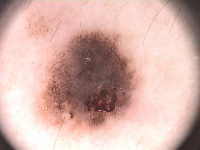</td><td>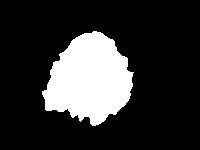</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [5]:
#!pip install googledrivedownloader

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

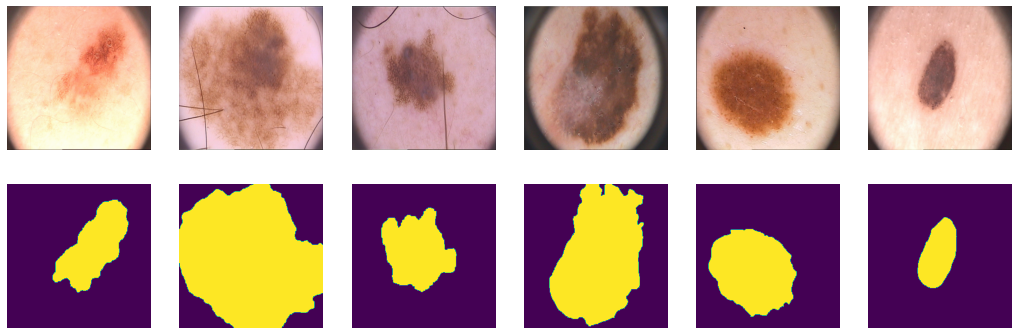

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150]) #indices

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


Добавим аугументацию для тренировочных данных

In [10]:
#!pip install -U torch torchvision

In [19]:
from torchvision import transforms

train_transform = transforms.Compose(
    [
        #transforms.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        #transforms.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        transforms.RandomHorizontalFlip()
    ]
)
X_train_add = train_transform(X[tr])
Y_train_add = train_transform(Y[tr])

Посмотрим, что получилось:

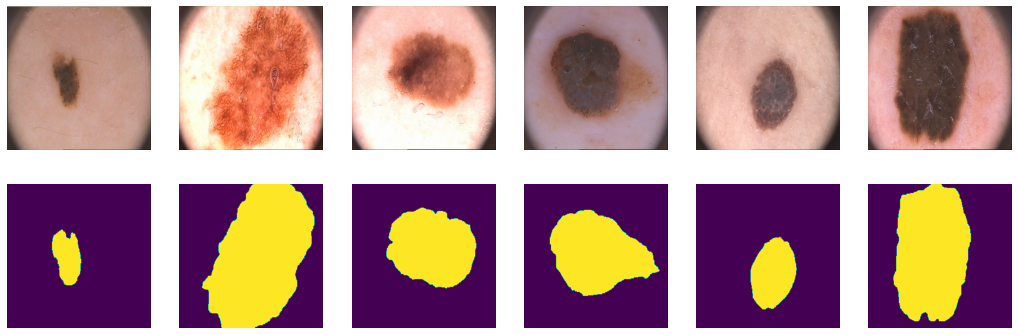

In [20]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X_train_add[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y_train_add[i])
plt.show();

In [28]:
X_train = np.concatenate((X[tr], X_train_add), axis=0)
Y_train = np.concatenate((Y[tr], Y_train_add), axis=0)
X_train.shape

(200, 256, 256, 3)

#### PyTorch DataLoader

In [29]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X_train, 3, 1), Y_train[:, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [32]:
for X_batch, Y_batch in data_tr:
    print(X_batch.size())

torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])


In [33]:
for X_val, Y_val in data_val:
    print(Y_val.size())

torch.Size([25, 1, 256, 256])
torch.Size([25, 1, 256, 256])


In [34]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [35]:
!nvidia-smi

Mon Jan 10 10:38:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

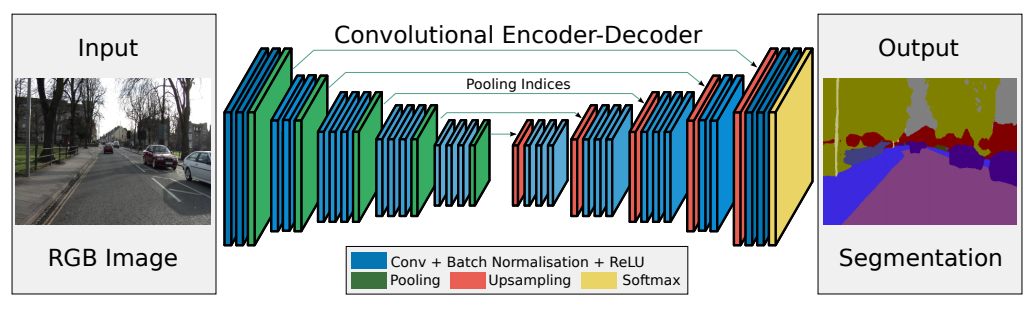

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import seaborn as sns

In [37]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm01 = nn.BatchNorm2d(64)
        self.enc_conv02 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm02 = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc_conv11 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batch_norm11 = nn.BatchNorm2d(128)
        self.enc_conv12 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.batch_norm12 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc_conv21 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batch_norm21 = nn.BatchNorm2d(256)
        self.enc_conv22 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.batch_norm22 = nn.BatchNorm2d(256)
        self.enc_conv23 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.batch_norm23 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc_conv31 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.batch_norm31 = nn.BatchNorm2d(512)
        self.enc_conv32 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.batch_norm32 = nn.BatchNorm2d(512)
        self.enc_conv33 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.batch_norm33 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck #финал энкодера и начало декодера
        
        self.enc_conv41 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.batch_norm41 = nn.BatchNorm2d(512)
        self.enc_conv42 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.batch_norm42 = nn.BatchNorm2d(512)
        self.enc_conv43 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.batch_norm43 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv41 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.dec_batch_norm41 = nn.BatchNorm2d(512)
        self.dec_conv42 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.dec_batch_norm42 = nn.BatchNorm2d(512)
        self.dec_conv43 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.dec_batch_norm43 = nn.BatchNorm2d(512)
        

        # decoder (upsampling)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv31 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.dec_batch_norm31 = nn.BatchNorm2d(512)
        self.dec_conv32 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.dec_batch_norm32 = nn.BatchNorm2d(512)
        self.dec_conv33 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.dec_batch_norm33 = nn.BatchNorm2d(256)
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv21 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.dec_batch_norm21 = nn.BatchNorm2d(256)
        self.dec_conv22 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.dec_batch_norm22 = nn.BatchNorm2d(256)
        self.dec_conv23 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.dec_batch_norm23 = nn.BatchNorm2d(128)
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv11 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.dec_batch_norm11 = nn.BatchNorm2d(128)
        self.dec_conv12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_batch_norm12 = nn.BatchNorm2d(64)
        
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv01 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.dec_batch_norm01 = nn.BatchNorm2d(64)
        self.dec_conv02 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0, id0 = self.pool0(F.relu(self.batch_norm02(self.enc_conv02(F.relu(self.batch_norm01(self.enc_conv01(x)))))))
        e1, id1 = self.pool1(F.relu(self.batch_norm12(self.enc_conv12(F.relu(self.batch_norm11(self.enc_conv11(e0)))))))
        e2, id2 = self.pool2(F.relu(self.batch_norm23(self.enc_conv23(F.relu(self.batch_norm22(self.enc_conv22(F.relu(self.batch_norm21(self.enc_conv21(e1))))))))))
        e3, id3 = self.pool3(F.relu(self.batch_norm33(self.enc_conv33(F.relu(self.batch_norm32(self.enc_conv32(F.relu(self.batch_norm31(self.enc_conv31(e2))))))))))

        # bottleneck
        
        e4, id4 = self.pool4(F.relu(self.batch_norm43(self.enc_conv43(F.relu(self.batch_norm42(self.enc_conv42(F.relu(self.batch_norm41(self.enc_conv41(e3))))))))))
        d4 = F.relu(self.dec_batch_norm43(self.dec_conv43(F.relu(self.dec_batch_norm42(self.dec_conv42(F.relu(self.dec_batch_norm41(self.dec_conv41(self.upsample4(e4, id4))))))))))

        # decoder
        d3 = F.relu(self.dec_batch_norm33(self.dec_conv33(F.relu(self.dec_batch_norm32(self.dec_conv32(F.relu(self.dec_batch_norm31(self.dec_conv31(self.upsample3(d4, id3))))))))))
        d2 = F.relu(self.dec_batch_norm23(self.dec_conv23(F.relu(self.dec_batch_norm22(self.dec_conv22(F.relu(self.dec_batch_norm21(self.dec_conv21(self.upsample2(d3, id2))))))))))
        d1 = F.relu(self.dec_batch_norm12(self.dec_conv12(F.relu(self.dec_batch_norm11(self.dec_conv11(self.upsample1(d2, id1)))))))
        d0 = self.dec_conv02(F.relu(self.dec_batch_norm01(self.dec_conv01(self.upsample0(d1, id0))))) # no activation
        
        return d0

In [38]:
from torchsummary import summary

model = SegNet().to(device)

In [39]:
summary(model, (3, 256, 256), 25)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
            Conv2d-3         [25, 64, 256, 256]          36,928
       BatchNorm2d-4         [25, 64, 256, 256]             128
         MaxPool2d-5  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-6        [25, 128, 128, 128]          73,856
       BatchNorm2d-7        [25, 128, 128, 128]             256
            Conv2d-8        [25, 128, 128, 128]         147,584
       BatchNorm2d-9        [25, 128, 128, 128]             256
        MaxPool2d-10  [[-1, 128, 64, 64], [-1, 128, 64, 64]]               0
           Conv2d-11          [25, 256, 64, 64]         295,168
      BatchNorm2d-12          [25, 256, 64, 64]             512
           Conv2d-13          [25, 256, 64, 64]         590,080
      Batch

In [40]:
!nvidia-smi

Mon Jan 10 10:39:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   1685MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [41]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [42]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch

    #вторая формула
    bce_loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))

    #первая формула
    #bce_loss = y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred))
    return bce_loss.mean()

In [43]:
# ДЛЯ ПРОВЕРКИ
import numpy as np

t1 = torch.randn(64, 1, 256, 256) #real (target)
t2 = torch.randn(64, 1, 256, 256) #pred (output)

print(nn.BCEWithLogitsLoss()(t2, t1), bce_loss(t2, t1))

tensor(0.8066) tensor(0.8066)


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [44]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler):

    start_time = time()

    train_losses = []
    val_losses = []

    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):  # цикл по эпохам
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        
        for X_batch, Y_batch in data_tr:    # цикл по батчам
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            #Y_pred = torch.sigmoid(model(X_batch))
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.detach().item() / len(data_tr)

            # избавиться от переполнения памяти
            X_batch = X_batch.cpu()
            Y_batch = Y_batch.cpu()
            Y_pred = Y_pred.cpu()
            del X_batch, Y_batch, Y_pred, loss
            torch.cuda.empty_cache()

        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode

        with torch.set_grad_enabled(False):
            outputs = model(X_val.to(device))
            Y_hat = outputs.detach().cpu() # detach and put into cpu
            #detach - чтобы перевести тензор, к которому привязаны градиенты, в нампай массив, сначала надо отвязать его от графа
        X_val = X_val.cpu()

        val_losses.append(loss_fn(Y_val, Y_hat))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        scheduler.step()

    end_time = time()

    return train_losses, val_losses, end_time - start_time

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [45]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [46]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))>0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [47]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters())

In [48]:
segnet_bce_scheduler = torch.optim.lr_scheduler.StepLR(optim, 10)

In [29]:
!nvidia-smi

Mon Jan  3 12:20:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |   1751MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

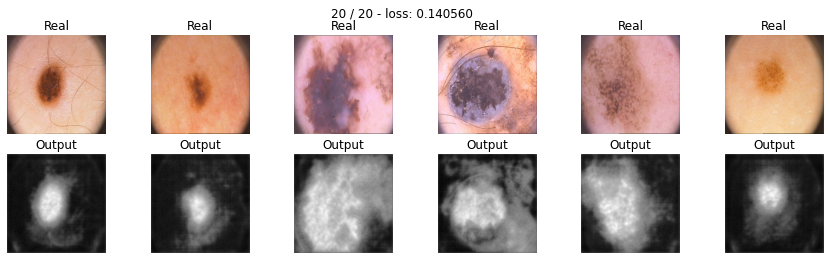

In [49]:
train_bce_losses, val_bce_losses, time_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val, segnet_bce_scheduler)

In [50]:
score_bce = score_model(model, iou_pytorch, data_ts)
print(score_bce)

0.7923515737056732


Ответьте себе на вопрос: не переобучается ли моя модель?

In [119]:
# построим график loss/epoch
def plot_trainig(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.title(title)
    plt.legend()

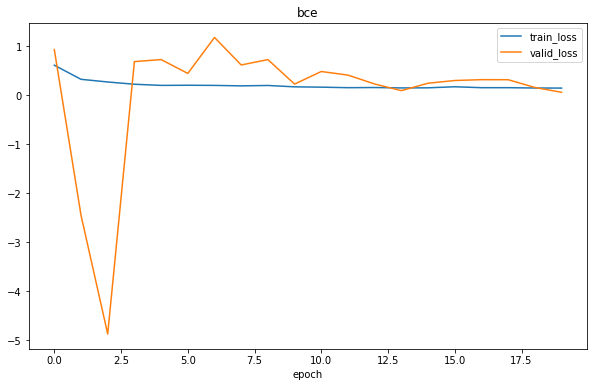

In [120]:
plot_trainig(train_bce_losses, val_bce_losses, 'bce')

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [53]:
def dice_loss(y_pred, y_real):
    smooth = 1e-8
    y_pred = torch.sigmoid(y_pred)
    num = torch.abs(2*(y_pred*y_real).sum((1,2,3))) + smooth
    den = (torch.abs(y_pred) + torch.abs(y_real)).sum((1,2,3)) + smooth
    res = 1 - (num/den).mean()
    return res

Проводим тестирование:

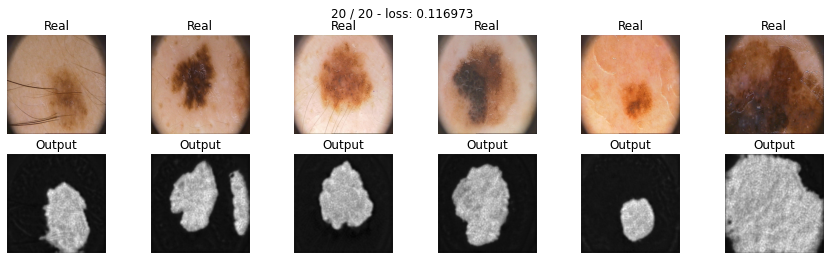

In [55]:
model_dice = SegNet().to(device)

max_epochs = 20
optimizer_dice = torch.optim.Adam(model_dice.parameters())
scheduler_dice = torch.optim.lr_scheduler.StepLR(optimizer_dice, 10)
train_dice_losses, val_dice_losses, time_dice = train(model_dice, optimizer_dice, dice_loss, max_epochs, data_tr, data_val, scheduler_dice)

In [56]:
score_dice = score_model(model_dice, iou_pytorch, data_ts)
print(score_dice)

0.7973670661449432


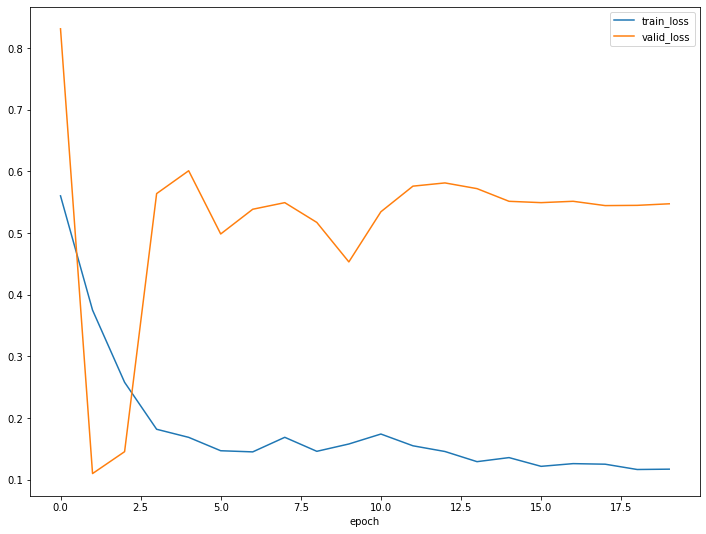

In [57]:
# построим график loss/epoch
plot_trainig(train_dice_losses, val_dice_losses)

In [58]:
# чистим память после segnet_dice
model_dice.cpu()
torch.cuda.empty_cache()

In [59]:
!nvidia-smi

Mon Jan 10 10:47:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    45W / 250W |   2547MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [60]:
def focal_loss(y_pred, y_real, alpha = 2, eps = 1e-8, gamma = 2):

    y_pred = torch.clamp(torch.sigmoid(y_pred), min = eps)

    bce = bce_loss(y_pred, y_real)
    bce_exp = torch.exp(-bce)

    loss = alpha * (1 - bce_exp)**gamma * bce
    return loss.mean()

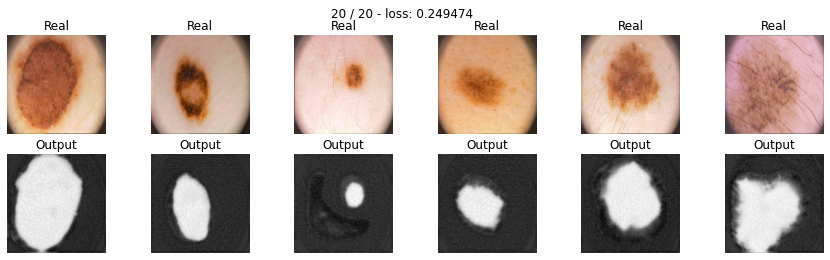

In [62]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer_focal = torch.optim.Adam(model_focal.parameters())
scheduler_focal = torch.optim.lr_scheduler.StepLR(optimaizer_focal, 10)
train_focal_losses, val_focal_losses, time_focal = train(model_focal, optimaizer_focal, focal_loss, max_epochs, data_tr, data_val, scheduler_focal)

In [63]:
score_focal = score_model(model_focal, iou_pytorch, data_ts)
print(score_focal)

0.7679973840713501


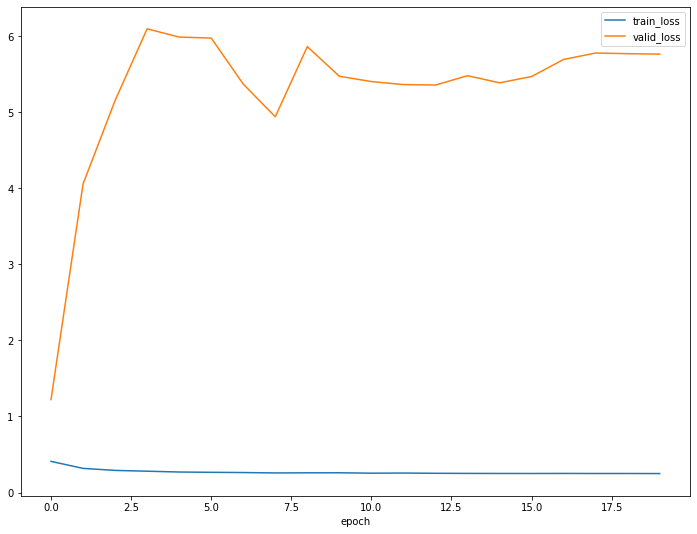

In [64]:
# построим график loss/epoch
plot_trainig(train_focal_losses, val_focal_losses)

In [65]:
# чистим память после segnet_focal
model_focal.cpu()
torch.cuda.empty_cache()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [71]:
#Tversky loss function
def tversky_loss(y_pred, y_real, alpha=0.3, beta=0.7):
    smooth = 1e-6
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    #True Positives, False Positives & False Negatives
    TP = (y_pred * y_real).sum()    
    FP = ((1 - y_real) * y_pred).sum()
    FN = (y_real * (1 - y_pred)).sum()

    num = TP + smooth
    den = TP + alpha*FP + beta*FN + smooth 
    res = 1 - num/den
    return res

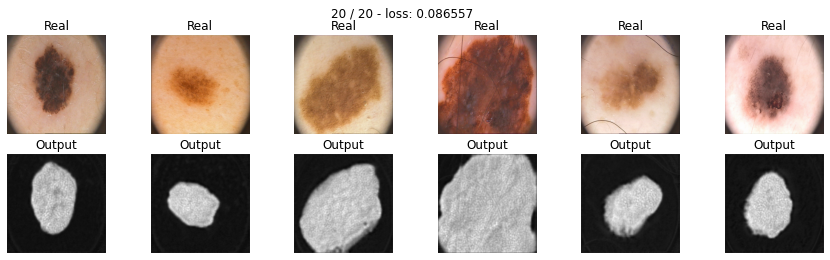

In [72]:
model_tversky = SegNet().to(device)

max_epochs = 20
optimaizer_tversky = torch.optim.Adam(model_tversky.parameters())
scheduler_tversky = torch.optim.lr_scheduler.StepLR(optimaizer_tversky, 10)
train_tversky_losses, val_tversky_losses, time_tversky = train(model_tversky, optimaizer_tversky, tversky_loss, max_epochs, data_tr, data_val, scheduler_tversky)

In [73]:
score_tversky = score_model(model_tversky, iou_pytorch, data_ts)
print(score_tversky)

0.7693568766117096


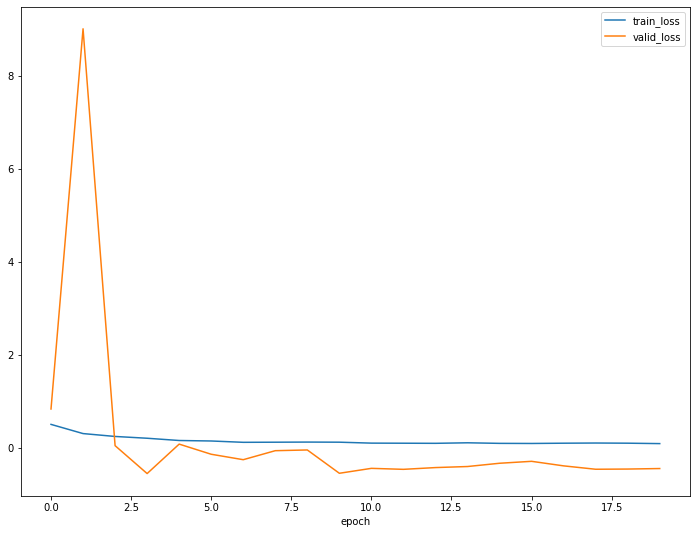

In [74]:
# построим график loss/epoch
plot_trainig(train_tversky_losses, val_tversky_losses)

In [75]:
# чистим память после segnet_tversky
model_tversky.cpu()
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

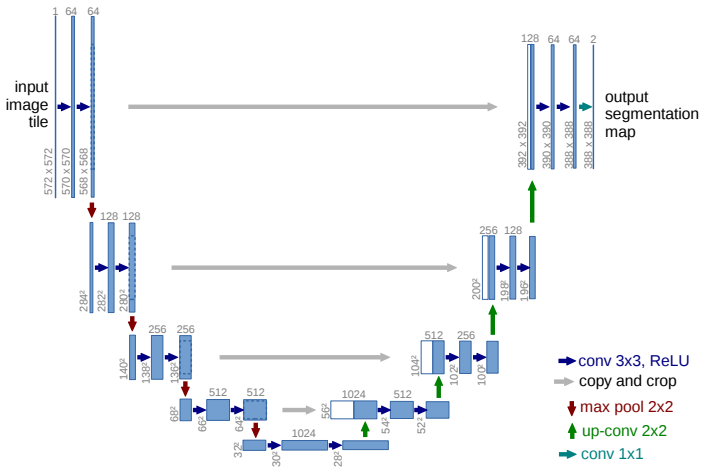

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [76]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(self.pool3(e3)))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([e3, b], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([e2, d0], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([e1, d1], dim=1)))
        d3 = self.dec_conv3(torch.cat([e0, d2], dim=1))  # no activation
        return d3

In [77]:
unet_model = UNet().to(device)

In [78]:
from torchsummary import summary

summary(unet_model, (3, 256, 256), 25)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
              ReLU-2         [25, 64, 256, 256]               0
            Conv2d-3         [25, 64, 256, 256]          36,928
              ReLU-4         [25, 64, 256, 256]               0
         MaxPool2d-5         [25, 64, 128, 128]               0
            Conv2d-6        [25, 128, 128, 128]          73,856
              ReLU-7        [25, 128, 128, 128]               0
            Conv2d-8        [25, 128, 128, 128]         147,584
              ReLU-9        [25, 128, 128, 128]               0
        MaxPool2d-10          [25, 128, 64, 64]               0
           Conv2d-11          [25, 256, 64, 64]         295,168
             ReLU-12          [25, 256, 64, 64]               0
           Conv2d-13          [25, 256, 64, 64]         590,080
             ReLU-14          [25, 256,

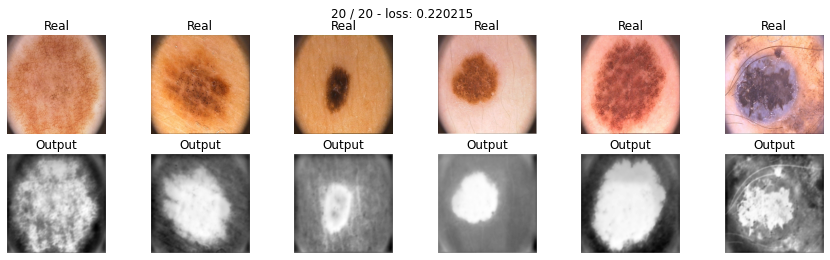

In [79]:
max_epochs = 20
optim = torch.optim.Adam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optim, 10)
train_unet_losses, val_unet_losses, time_unet = train(unet_model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [80]:
score_unet = score_model(unet_model, iou_pytorch, data_ts)
print(score_unet)

0.7523784041404724


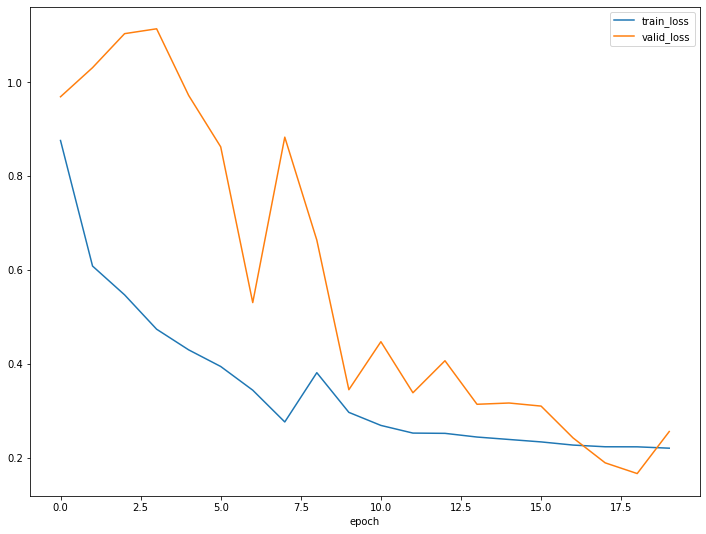

In [81]:
# построим график loss/epoch
plot_trainig(train_unet_losses, val_unet_losses)

In [82]:
# чистим память после unet_model
unet_model.cpu()
torch.cuda.empty_cache()
!nvidia-smi

Mon Jan 10 11:03:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    40W / 250W |   5273MiB / 16280MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [83]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),  # 256 -> 128
            nn.ReLU()
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0), # 128 -> 64
            nn.ReLU()
        )

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0), # 64 -> 32
            nn.ReLU()
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0), # 32 -> 16
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(self.pool3(e3)))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([e3, b], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([e2, d0], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([e1, d1], dim=1)))
        d3 = self.dec_conv3(torch.cat([e0, d2], dim=1))  # no activation
        return d3

In [84]:
unet2_model = UNet2().to(device)


In [85]:
from torchsummary import summary

summary(unet2_model, (3, 256, 256), 25)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
              ReLU-2         [25, 64, 256, 256]               0
            Conv2d-3         [25, 64, 256, 256]          36,928
              ReLU-4         [25, 64, 256, 256]               0
            Conv2d-5         [25, 64, 128, 128]          16,448
              ReLU-6         [25, 64, 128, 128]               0
            Conv2d-7        [25, 128, 128, 128]          73,856
              ReLU-8        [25, 128, 128, 128]               0
            Conv2d-9        [25, 128, 128, 128]         147,584
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11          [25, 128, 64, 64]          65,664
             ReLU-12          [25, 128, 64, 64]               0
           Conv2d-13          [25, 256, 64, 64]         295,168
             ReLU-14          [25, 256,

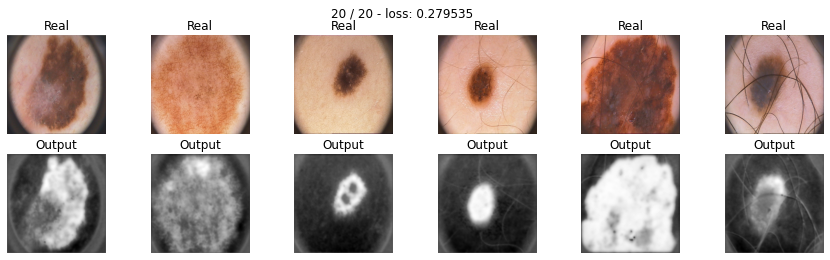

In [86]:
max_epochs = 20
optim = torch.optim.Adam(unet2_model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optim, 10)
train_unet2_losses, val_unet2_losses, time_unet2 = train(unet2_model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [87]:
score_unet2 = score_model(unet2_model, iou_pytorch, data_ts)
print(score_unet2)

0.6230023205280304


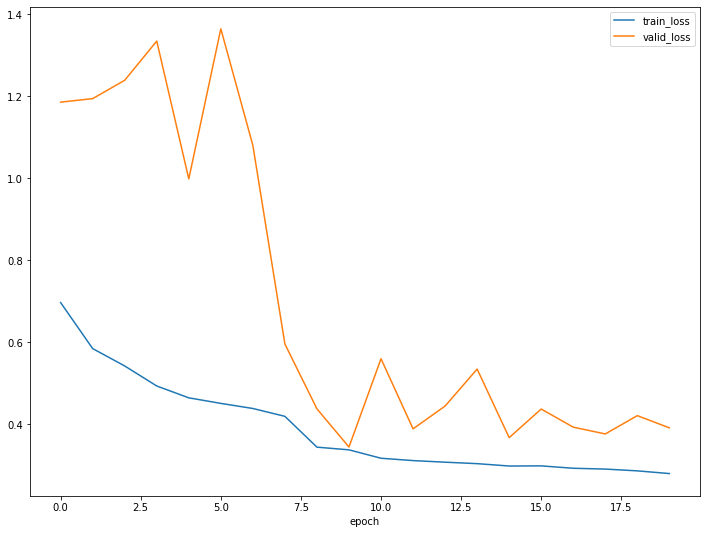

In [88]:
# построим график loss/epoch
plot_trainig(train_unet2_losses, val_unet2_losses)

In [89]:
# чистим память после unet_model
unet2_model.cpu()
torch.cuda.empty_cache()
!nvidia-smi

Mon Jan 10 11:06:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    47W / 250W |   5281MiB / 16280MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Сделайте вывод, какая из моделей лучше

In [90]:
if(score_unet >= score_unet2):
  print('Unet is better')
else:
  print('Unet2 is better')

Unet is better


# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Сравним значения обучения моделей: SegNet с разными функциями потерь и 2 варианты Unet с bce loss

Сравним время обучения сетей на 20 эпохах:

<BarContainer object of 6 artists>

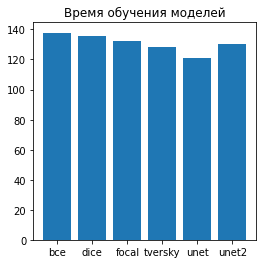

In [96]:
data_names = ['bce', 'dice', 'focal', 'tversky', 'unet', 'unet2']
data_values = [time_bce, time_dice, time_focal, time_tversky, time_unet, time_unet2]
fig = plt.figure(figsize = (4, 4))
plt.title('Время обучения моделей')
plt.bar(data_names, data_values)

In [97]:
min(time_bce, time_dice, time_focal, time_tversky, time_unet, time_unet2)

121.07180953025818

In [98]:
max(time_bce, time_dice, time_focal, time_tversky, time_unet, time_unet2)

137.82495832443237

Из диаграммы видно, что быстрее всего обучалась Unet, ее время обучения составило 121 секунду.

Дольше всех обучалась SegNet с функцией потерь bce, время обучения составило 138 секунд.

Теперь сравним графики функций потерь по эпохам.

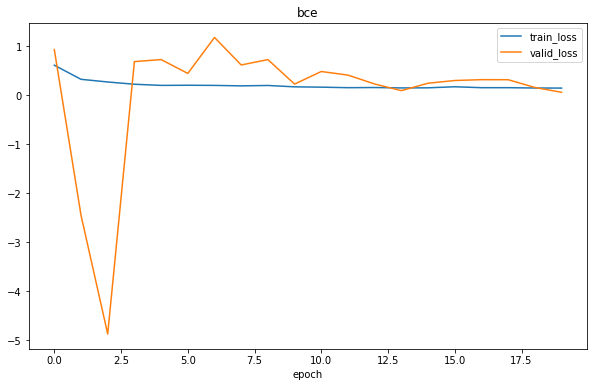

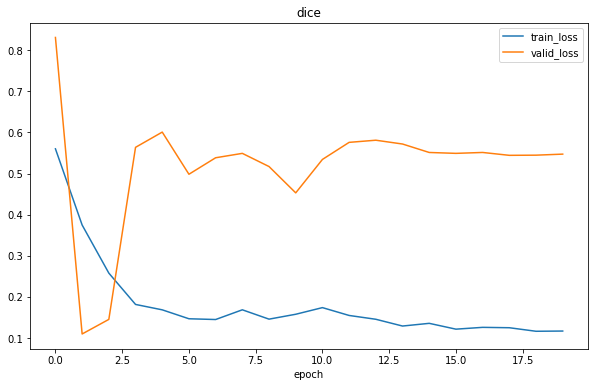

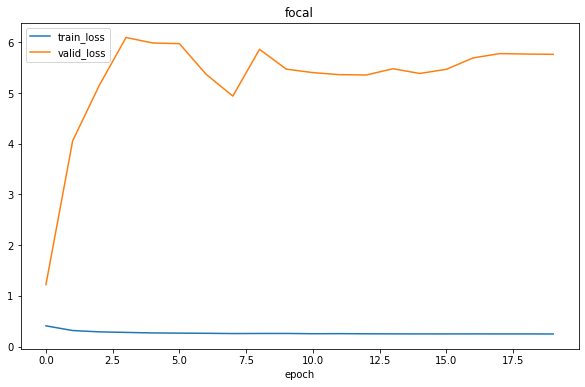

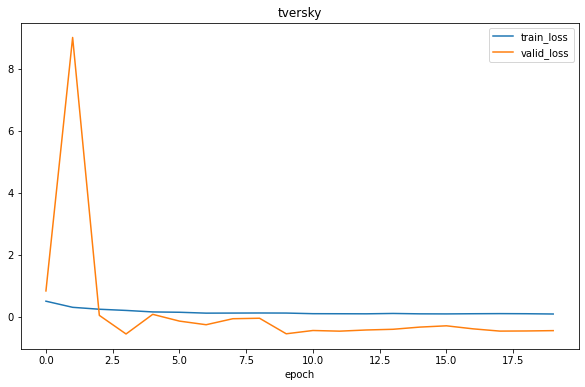

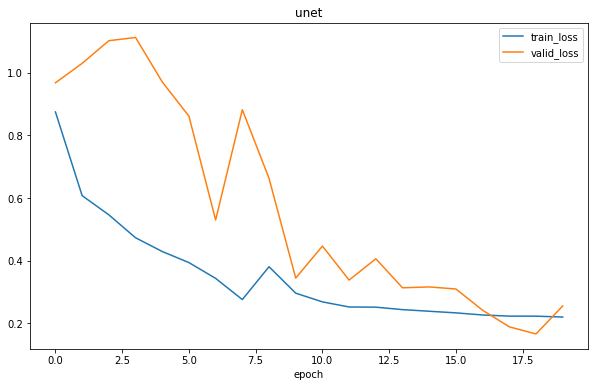

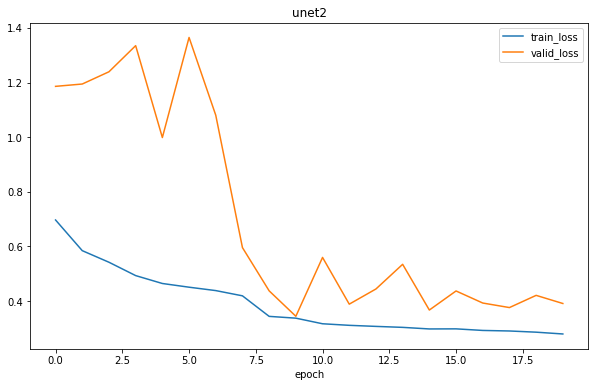

In [121]:
train_loss = [train_bce_losses, train_dice_losses, train_focal_losses, train_tversky_losses, train_unet_losses, train_unet2_losses]
val_loss = [val_bce_losses, val_dice_losses, val_focal_losses, val_tversky_losses, val_unet_losses, val_unet2_losses]
for i in range(len(data_names)):
  plot_trainig(train_loss[i], val_loss[i], data_names[i])

Построим на одном графике для наглядности

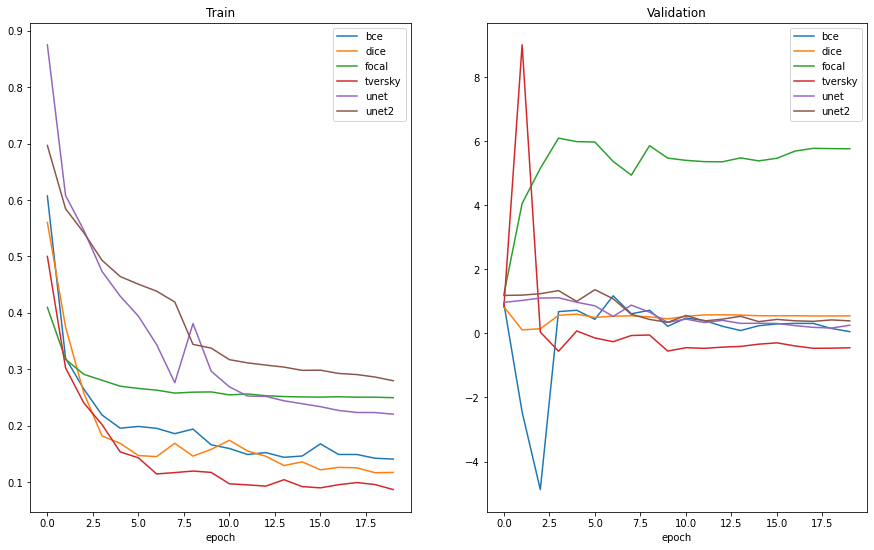

In [164]:
plt.figure(figsize=(15, 9))

plt.subplot(121)
plt.xlabel('epoch')
for i in range(len(train_loss)):
  plt.plot(train_loss[i], label=data_names[i])
plt.title('Train')
plt.legend(loc='upper right')

plt.subplot(122)
plt.xlabel('epoch')
for i in range(len(train_loss)):
  plt.plot(val_loss[i], label=data_names[i])
plt.title('Validation')
plt.legend(loc='upper right')

plt.show()

Судя по графикам потерь для обучающей выборки, с наилучшей стороны показали себя модель Segnet с функцией потерь focal loss, dice loss и bce loss.

Для выборки валидации же лучше работали модель Segnet с функцией потерь bce loss, а так же Unet и Unet2.

Оценим качество моделей на тестовой выборке по iou метрике

<BarContainer object of 6 artists>

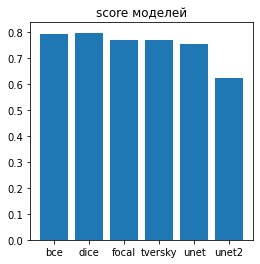

In [165]:
data_names = ['bce', 'dice', 'focal', 'tversky', 'unet', 'unet2']
data_values = [score_bce, score_dice, score_focal, score_tversky, score_unet, score_unet2]
fig = plt.figure(figsize = (4, 4))
plt.title('score моделей')
plt.bar(data_names, data_values)

Оцениявая разные модели по метрике, можно выделить Segnet с функцией потерь dice loss и bce loss как наилучшие модели.
Модель Unet2 же показала достаточно плохой результат при оценке по метрике на тестовой выборке.

Вывод:

Таким образом, в качестве наиболее эффективной модели при решении задачи сегментации, я использовала бы модель Segnet с функцией потерь bce loss. Несмотря на то, что ее обучение составило максимальное время из всех рассмотренных моделей, она показала наилучшие результаты на выборке валидации и тестовой выборках.